# NLP Pipeline Refatorado

Pipeline completo para processamento de texto, geração de embeddings
(Word2Vec) e classificação com LSTM, usando arquitetura orientada a objetos,
tratamento de erros e logging.

Este notebook atua apenas como **orquestrador** do pipeline.

In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parents[1]
sys.path.append(str(PROJECT_ROOT))

In [5]:
from src.config.settings import (
    DATASET_PATH,
    MAX_SEQUENCE_LENGTH
)

from src.data.data_loader import DataLoader

In [6]:
loader = DataLoader(DATASET_PATH)
df = loader.load()
df.head()

[2026-02-10 03:13:13,350] [INFO] DataLoader - Loading data from C:\Users\User\Desktop\covid-19\data-science-machine-learning-for-covid-19-using-python-project-3\src\data\updated_train.csv


,ID,text,target
0,train_0,The bitcoin halving is cancelled due to,1
1,train_1,MercyOfAllah In good times wrapped in its gran...,0
2,train_2,266 Days No Digital India No Murder of e learn...,1
3,train_3,India is likely to run out of the remaining RN...,1
4,train_4,In these tough times the best way to grow is t...,0


In [7]:
df.head()

,ID,text,target
0,train_0,The bitcoin halving is cancelled due to,1
1,train_1,MercyOfAllah In good times wrapped in its gran...,0
2,train_2,266 Days No Digital India No Murder of e learn...,1
3,train_3,India is likely to run out of the remaining RN...,1
4,train_4,In these tough times the best way to grow is t...,0


In [8]:
from src.data.dataframe_schema import DataFrameSchema
schema = DataFrameSchema(required_columns=["text", "target"])
df = schema.apply(df)
df.head()

[2026-02-10 03:13:14,815] [INFO] DataFrameSchema - Validação de schema concluída com sucesso
[2026-02-10 03:13:14,817] [INFO] DataFrameSchema - Aplicando schema com colunas: ['text', 'target']


,text,target
0,The bitcoin halving is cancelled due to,1
1,MercyOfAllah In good times wrapped in its gran...,0
2,266 Days No Digital India No Murder of e learn...,1
3,India is likely to run out of the remaining RN...,1
4,In these tough times the best way to grow is t...,0


In [9]:
from src.nlp.text_preprocessor import TextPreprocessor
preprocessor = TextPreprocessor(language="english")
review_lines = preprocessor.preprocess_dataframe(df, text_column="text")

[2026-02-10 03:13:19,050] [INFO] TextPreprocessor - TextPreprocessor inicializado (language=english)
[2026-02-10 03:13:19,050] [INFO] TextPreprocessor - Iniciando pré-processamento da coluna 'text'
[2026-02-10 03:13:20,226] [INFO] TextPreprocessor - Pré-processamento concluído (5287 registros)


In [10]:
review_lines

[['bitcoin', 'halving', 'cancelled', 'due'],
 ['mercyofallah',
  'good',
  'times',
  'wrapped',
  'granular',
  'detail',
  'challenge',
  'find',
  'meaning',
  'model',
  'humility'],
 ['days',
  'digital',
  'india',
  'murder',
  'e',
  'learning',
  'online',
  'business',
  'restore',
  'j',
  'amp',
  'k'],
 ['india',
  'likely',
  'run',
  'remaining',
  'rna',
  'kits',
  'essential',
  'testing',
  'one',
  'week',
  'gov'],
 ['tough',
  'times',
  'best',
  'way',
  'grow',
  'learn',
  'case',
  'teach',
  'help',
  'people',
  'learn',
  'connect',
  'sports',
  'anal'],
 ['fifa',
  'proposed',
  'allowing',
  'teams',
  'make',
  'five',
  'substitutions',
  'per',
  'match',
  'help',
  'players',
  'cope',
  'return',
  'action'],
 ['lovers',
  'sports',
  'especially',
  'know',
  'sometimes',
  'time',
  'changes',
  'done',
  'name',
  'daylight',
  'saving',
  'time',
  'dst',
  'practice',
  'setting',
  'clocks',
  'forward',
  'one',
  'hour',
  'standard',
  't

In [11]:
from src.nlp.word2vec_trainer import Word2VecTrainer

trainer = Word2VecTrainer(vector_size=100, window=5)
w2v_model = trainer.train(review_lines)

trainer.save_embeddings(
    output_path="models/covid_tweet_embedding_word2vec.txt",
    binary=False
)

[2026-02-10 03:13:21,547] [INFO] Word2VecTrainer - Word2VecTrainer inicializado (vector_size=100, window=5, min_count=1, workers=4)
[2026-02-10 03:13:21,550] [INFO] Word2VecTrainer - Iniciando treinamento do Word2Vec
[2026-02-10 03:13:22,376] [INFO] Word2VecTrainer - Treinamento concluído (vocabulário=13431 palavras)
[2026-02-10 03:13:22,384] [INFO] Word2VecTrainer - Salvando embeddings em models\covid_tweet_embedding_word2vec.txt
[2026-02-10 03:13:24,176] [INFO] Word2VecTrainer - Embeddings salvos com sucesso


In [12]:
w2v_model.wv.most_similar('lockdown')

[('amp', 0.9951995015144348),
 ('people', 0.9951446056365967),
 ('sports', 0.9946950078010559),
 ('like', 0.9946545958518982),
 ('us', 0.9940623641014099),
 ('today', 0.9940029978752136),
 ('new', 0.9939184784889221),
 ('trump', 0.9936910271644592),
 ('health', 0.9934712052345276),
 ('make', 0.9934625029563904)]

In [13]:
from src.nlp.embedding_loader import EmbeddingLoader

loader = EmbeddingLoader("models/covid_tweet_embedding_word2vec.txt")
embedding_index = loader.load()


[2026-02-10 03:13:26,276] [INFO] EmbeddingLoader - EmbeddingLoader inicializado: models\covid_tweet_embedding_word2vec.txt
[2026-02-10 03:13:26,278] [INFO] EmbeddingLoader - Iniciando leitura do arquivo de embeddings
[2026-02-10 03:13:27,081] [INFO] EmbeddingLoader - Embeddings carregados com sucesso (13432 palavras)


In [14]:
embedding_index

{'13431': array([100.], dtype=float32),
 'ramadan': array([-1.18802473e-01,  1.58895001e-01,  1.11633483e-02,  8.57570991e-02,
         9.25661549e-02, -2.89091587e-01,  7.92803988e-02,  4.17549312e-01,
        -6.04183301e-02, -5.49092293e-02, -4.73539829e-02, -3.02669138e-01,
        -7.29394332e-02,  2.06366926e-01,  7.90318176e-02, -1.57095775e-01,
         6.87824488e-02, -2.23263249e-01,  6.33957461e-02, -3.24921548e-01,
         1.16781190e-01,  1.05618164e-01,  1.15327336e-01, -9.48361829e-02,
         6.93033189e-02, -1.94724277e-02, -1.90879837e-01, -5.42784519e-02,
        -1.68311551e-01, -5.77976555e-02,  2.36542031e-01,  2.39959937e-02,
         2.82246247e-02, -1.24967888e-01, -6.95705786e-02,  1.50908411e-01,
        -2.96766907e-02, -1.98309705e-01, -6.77088872e-02, -3.53939474e-01,
        -1.99356060e-02, -1.58565208e-01, -1.12266399e-01, -1.54365003e-02,
         1.56563684e-01, -9.37843993e-02, -1.70311883e-01, -2.13242639e-02,
         1.56201169e-01,  1.57660559e

In [15]:
from src.data.dataset_splitter import DatasetSplitter

splitter = DatasetSplitter(train_end_index=4200)

x_train, y_train, x_test, y_test = splitter.split(df)


[2026-02-10 03:13:30,579] [INFO] DatasetSplitter - DatasetSplitter inicializado (text=text, target=target, train_end_index=4200, train_ratio=None)
[2026-02-10 03:13:30,582] [INFO] DatasetSplitter - Separando dataset (train_size=4201)
[2026-02-10 03:13:30,585] [INFO] DatasetSplitter - Split concluído (train=4201, test=1086)


In [16]:
from src.nlp.sequence_builder import SequenceBuilder
builder = SequenceBuilder(max_length=100, test_split=0.2)
x_train, y_train, x_test, y_test = builder.build(
    texts=review_lines,
    labels=df["target"].values
)

[2026-02-10 03:13:40,819] [INFO] SequenceBuilder - SequenceBuilder inicializado (max_length=100, test_split=0.20)
[2026-02-10 03:13:40,820] [INFO] SequenceBuilder - Tokenizando textos
[2026-02-10 03:13:41,145] [INFO] SequenceBuilder - Split concluído (train=4230, test=1057)


In [22]:
from src.models.lstm_embedding_classifier import LSTMEmbeddingClassifier
import matplotlib.pyplot as plt

# =========================
# Modelo
# =========================

word_index = tokenizer.word_index
num_words = len(word_index) + 1

EMBEDDING_DIM = 100
max_length = 100

classifier = LSTMEmbeddingClassifier(
    num_words=num_words,
    embedding_dim=EMBEDDING_DIM,
    embedding_matrix=embedding_matrix,
    max_length=max_length,
)

model = classifier.build()

# OPÇÃO 2 (opcional, só para summary)
model.build(input_shape=(None, max_length))
model.summary()

[2026-02-10 03:21:59,710] [INFO] LSTMEmbeddingClassifier - LSTMEmbeddingClassifier inicializado (num_words=14329, embedding_dim=100, max_length=100)
[2026-02-10 03:21:59,711] [INFO] LSTMEmbeddingClassifier - Construindo modelo LSTM
[2026-02-10 03:21:59,799] [INFO] LSTMEmbeddingClassifier - Modelo LSTM construído e compilado com sucesso


C:\Users\User\Desktop\covid-19\data-science-machine-learning-for-covid-19-using-python-project-3\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 100)            │       1,432,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 32)                  │          17,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,449,957 (5.53 MB)

 Trainable params: 17,057 (66.63 KB)

 Non-trainable params: 1,432,900 (5.47 MB)

In [23]:
from src.nlp.sequence_builder import SequenceBuilder

seq_builder = SequenceBuilder(max_length=100, test_split=0.2)

x_train_pad, y_train_pad, x_test_pad, y_test_pad = seq_builder.build(
    texts=df["text"].tolist(),
    labels=df["target"].values,
)

tokenizer = seq_builder.get_tokenizer()


[2026-02-10 03:22:01,810] [INFO] SequenceBuilder - SequenceBuilder inicializado (max_length=100, test_split=0.20)
[2026-02-10 03:22:01,812] [INFO] SequenceBuilder - Tokenizando textos
[2026-02-10 03:22:02,195] [INFO] SequenceBuilder - Split concluído (train=4230, test=1057)


In [24]:
from src.nlp.embedding_matrix_builder import EmbeddingMatrixBuilder

builder = EmbeddingMatrixBuilder(embedding_dim=100)

embedding_matrix = builder.build(
    word_index=tokenizer.word_index,
    embedding_index=embedding_index
)

from src.nlp.embedding_matrix_builder import EmbeddingMatrixBuilder

embedding_builder = EmbeddingMatrixBuilder(embedding_dim=100)

embedding_matrix = embedding_builder.build(
    word_index=tokenizer.word_index,
    embedding_index=embedding_index,
)


[2026-02-10 03:22:02,961] [INFO] EmbeddingMatrixBuilder - EmbeddingMatrixBuilder inicializado (embedding_dim=100)
[2026-02-10 03:22:02,963] [INFO] EmbeddingMatrixBuilder - Construindo matriz de embeddings (num_words=14329)
[2026-02-10 03:22:02,985] [INFO] EmbeddingMatrixBuilder - Matriz construída (hits=13431, misses=897)
[2026-02-10 03:22:02,987] [INFO] EmbeddingMatrixBuilder - EmbeddingMatrixBuilder inicializado (embedding_dim=100)
[2026-02-10 03:22:02,990] [INFO] EmbeddingMatrixBuilder - Construindo matriz de embeddings (num_words=14329)
[2026-02-10 03:22:03,022] [INFO] EmbeddingMatrixBuilder - Matriz construída (hits=13431, misses=897)


In [25]:
from src.training.trainer import Trainer

trainer = Trainer(
    model=model,
    batch_size=64,
    epochs=25,
)

history = trainer.fit(
    x_train=x_train_pad,
    y_train=y_train_pad,
    x_val=x_test_pad,
    y_val=y_test_pad,
)


[2026-02-10 03:22:57,985] [INFO] Trainer - Iniciando treinamento do modelo
Epoch 1/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - accuracy: 0.5468 - loss: 0.6633 - val_accuracy: 0.6481 - val_loss: 0.6289
Epoch 2/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.6402 - loss: 0.6292 - val_accuracy: 0.6566 - val_loss: 0.6179
Epoch 3/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.6546 - loss: 0.6170 - val_accuracy: 0.6689 - val_loss: 0.6085
Epoch 4/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.6702 - loss: 0.6084 - val_accuracy: 0.6887 - val_loss: 0.6000
Epoch 5/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.6735 - loss: 0.6018 - val_accuracy: 0.6954 - val_loss: 0.5881
Epoch 6/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.6929 - loss: 0.5911 - val_accuracy: 0.7029 - val_loss: 0.5786
Epoch 7/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.6974 - loss: 0.5817 - val_accuracy: 0.7020 - val_loss: 0.5903
Epoch 8/25
67/67 ━━━━━━━━━━━━━━━━━━

In [26]:
from src.training.evaluator import Evaluator

evaluator = Evaluator(model=model, batch_size=64)

score, acc = evaluator.evaluate(
    x_test=x_test_pad,
    y_test=y_test_pad,
)

print(f"Score (loss): {score:.4f}")
print(f"Accuracy: {acc:.4f}")


[2026-02-10 03:26:51,168] [INFO] Evaluator - Iniciando avaliação do modelo
[2026-02-10 03:26:51,622] [INFO] Evaluator - Avaliação concluída (loss=0.4996, accuracy=0.7493)
Score (loss): 0.4996
Accuracy: 0.7493


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
[2026-02-10 03:29:56,330] [INFO] TrainingPlotter - Plotando acurácia


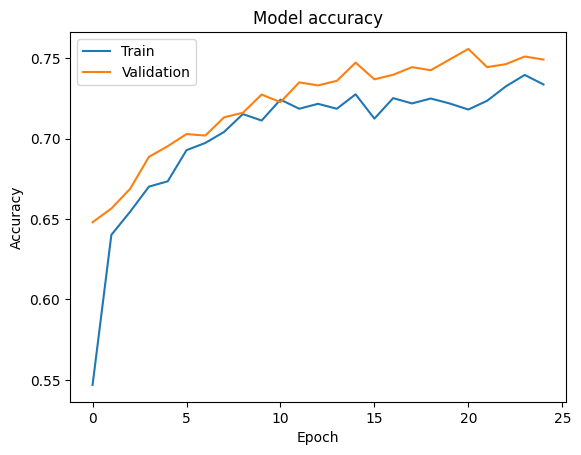

[2026-02-10 03:29:56,610] [INFO] TrainingPlotter - Plotando loss


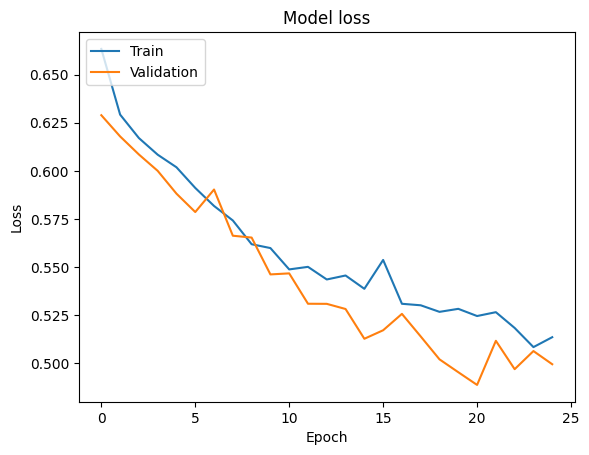

In [28]:
from src.visualization.training_plotter import TrainingPlotter

print(history.history.keys())

plotter = TrainingPlotter(history.history)

plotter.plot_accuracy()
plotter.plot_loss()
